In [1]:
import text2emotion as te
import pandas as pd
import numpy as np

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\parke\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\parke\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\parke\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
import time

class TimerError(Exception):
    """A custom exception used to report errors in use of Timer class"""

class Timer:
    def __init__(self):
        self._start_time = None

    def start(self):
        """Start a new timer"""
        if self._start_time is not None:
            raise TimerError(f"Timer is running. Use .stop() to stop it")

        self._start_time = time.perf_counter()

    def stop(self):
        """Stop the timer, and report the elapsed time"""
        if self._start_time is None:
            raise TimerError(f"Timer is not running. Use .start() to start it")

        elapsed_time = time.perf_counter() - self._start_time
        self._start_time = None
        print(f"Elapsed time: {elapsed_time:0.4f} seconds")

In [29]:
def getConversations(s,e):
    train = pd.read_csv("train.csv")
    train = train.iloc[:, :7].dropna()
    selfeval = train['selfeval']
    train["empathy"] = selfeval.str.extract('\d\|\d\|\d_(\d)\|\d\|\d')
    train = train.dropna()
    conversations = train["conv_id"].value_counts()
    conversations = conversations[s:e]
    lsconv = []
    i = 0
    for ids in conversations.index:
        convo = train.loc[train["conv_id"] == ids]
        convo = convo.drop(columns=["utterance_idx", "selfeval", "conv_id"])
        if len(convo["speaker_idx"].unique()) !=2:
            continue
        s1id = convo["speaker_idx"].unique()[0]
        s2id = convo["speaker_idx"].unique()[1]
        s1 = convo.loc[convo["speaker_idx"] == s1id]
        s2 = convo.loc[convo["speaker_idx"] == s2id]
        s1words = [s.replace("_comma_", ",") for s in s1["utterance"].values.tolist()]
        s2words = [s.replace("_comma_", ",") for s in s2["utterance"].values.tolist()]
        context = convo["context"].str.extract('(\w+)').values[0].item()
        escore = int(convo["empathy"].values[0])
        prompt = [convo["prompt"].unique()[0]]
        lsconv.append([context, prompt + s1words, s2words, escore])
        
        if i % 100 == 0:
            print(i)
        i +=1
    return lsconv

def getLabels():
    train = pd.read_csv("train.csv")
    train = train.iloc[:, :7].dropna()
    selfeval = train['selfeval']
    train["empathy"] = selfeval.str.extract('(\d)\|\d\|\d_\d\|\d\|\d')
    train["r"] = selfeval.str.extract('\d\|(\d)\|\d_\d\|\d\|\d')
    train["f"] = selfeval.str.extract('\d\|\d\|(\d)_\d\|\d\|\d')
    train = train.dropna()
    conversations = train["conv_id"].value_counts()
    labels = []
    i = 0
    for ids in conversations.index:
        convo = train.loc[train["conv_id"] == ids]
        convo = convo.drop(columns=["utterance_idx", "selfeval", "conv_id"])
        if len(convo["speaker_idx"].unique()) !=2:
            continue
        escore = int(convo["empathy"].values[0])
        rscore = int(convo["r"].values[0])
        fscore = int(convo["f"].values[0])
        labels.append([escore, rscore, fscore])
        
        if i % 1000 == 0:
            print(i)
        i +=1
    return labels

def empathy(prompt, response):
    # Gets just the emotion values for each statement.
    promptEmotions = list(te.get_emotion(prompt).values())
    responseEmotions = list(te.get_emotion(response).values())
    # Calculates the distance between the emotion vectors.
    return promptEmotions+ responseEmotions
          
def testing(s,e):
    conversations = getConversations(s,e)
    person1 = " ".join(conversations[0][1])
    person2 = " ".join(conversations[0][2])
    values = np.array(empathy(person1, person2))
    values = np.reshape(values, (1,10))
    for i in range(1, len( conversations)):
        person1 = " ".join(conversations[i][1])
        person2 = " ".join(conversations[i][2])
        temp = np.array(empathy(person1, person2))
        temp = np.reshape(temp, (1,10))
        values = np.append(values, temp, axis = 0)
    return values


X is a 18,108 by 10 (where the 10 is the five emotion values for speaker1 and the five emotion values for speaker2)
Y is a 18,108 by 1 (where this is just the empathy score that is in the dataset)


In [31]:
labelstest = getLabels()
labelstest= np.array(labelstest)

c:\users\parke\onedrive\documents\github\citrusenv\lib\site-packages\IPython\core\interactiveshell.py:3357: DtypeWarning: Columns (1,4,8,9) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000


(array([7.7000e+01, 0.0000e+00, 9.9000e+01, 0.0000e+00, 3.8600e+02,
        0.0000e+00, 1.4960e+03, 0.0000e+00, 1.6105e+04, 6.0000e+00]),
 array([1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. , 5.5, 6. ]),
 <BarContainer object of 10 artists>)

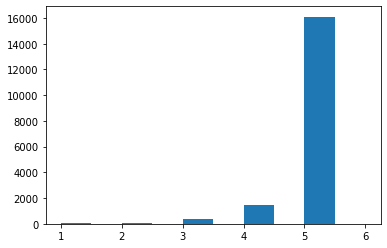

In [34]:
e=list(list(zip(*labelstest))[0]) 
r=list(list(zip(*labelstest))[1]) 
f=list(list(zip(*labelstest))[2]) 
from matplotlib import pyplot as plt
plt.hist(f)


In [5]:
n000 = np.load("0000s.npy")

o1000 = testing(1000,1001)
n1000 = np.load("1000s.npy")

o2000 = testing(2000,2001)
n2000 = np.load("2000s.npy")

o3000 = testing(3000,3001)
n3000 = np.load("3000s.npy")

o4000 = testing(4000,4001)
n4000 = np.load("4000s.npy")

o5000 = testing(5000,5001)
n5000 = np.load("5000s.npy")

o6000 = testing(6000,6001)
n6000 = np.load("6000s.npy")

o7000 = testing(7000,7001)
n7000 = np.load("7000s.npy")

o8000 = testing(8000,8001)
n8000 = np.load("8001-11000s.npy")

o11000 = testing(11000,11001)
n18000 = np.load("18000s.npy")
end = np.load("18208.npy")
allstest = np.concatenate((n000,  o1000, n1000,o2000, n2000, o3000, n3000, o4000,n4000,o5000,n5000 , 
                       o6000,n6000,o7000, n7000, o8000,n8000,o11000,n18000, end))
allstest.shape


c:\users\parke\onedrive\documents\github\citrusenv\lib\site-packages\IPython\core\interactiveshell.py:3437: DtypeWarning: Columns (1,4,8,9) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


0


c:\users\parke\onedrive\documents\github\citrusenv\lib\site-packages\IPython\core\interactiveshell.py:3437: DtypeWarning: Columns (1,4,8,9) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


0


c:\users\parke\onedrive\documents\github\citrusenv\lib\site-packages\IPython\core\interactiveshell.py:3437: DtypeWarning: Columns (1,4,8,9) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


0


c:\users\parke\onedrive\documents\github\citrusenv\lib\site-packages\IPython\core\interactiveshell.py:3437: DtypeWarning: Columns (1,4,8,9) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


0


c:\users\parke\onedrive\documents\github\citrusenv\lib\site-packages\IPython\core\interactiveshell.py:3437: DtypeWarning: Columns (1,4,8,9) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


0


c:\users\parke\onedrive\documents\github\citrusenv\lib\site-packages\IPython\core\interactiveshell.py:3437: DtypeWarning: Columns (1,4,8,9) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


0


c:\users\parke\onedrive\documents\github\citrusenv\lib\site-packages\IPython\core\interactiveshell.py:3437: DtypeWarning: Columns (1,4,8,9) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


0


c:\users\parke\onedrive\documents\github\citrusenv\lib\site-packages\IPython\core\interactiveshell.py:3437: DtypeWarning: Columns (1,4,8,9) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


0


c:\users\parke\onedrive\documents\github\citrusenv\lib\site-packages\IPython\core\interactiveshell.py:3437: DtypeWarning: Columns (1,4,8,9) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


0


(18169, 10)

In [10]:
alls = allstest.copy()
labels = labelstest.copy()

# remove 6 and 0 
print(np.unique(labels))
w = np.where(labels == 0)
labels = np.delete(labels, w)
alls = np.delete(alls, w, axis = 0)
w = np.where(labels == 6)
labels = np.delete(labels, w)
alls = np.delete(alls, w, axis = 0)
print(labels.shape)
print(alls.shape)
print(np.unique(labels))

[0 1 2 3 4 5 6]
(18159,)
(18159, 10)
[1 2 3 4 5]


In [11]:
np.save("labels.npy", labels)
np.save("data.npy", alls)

0.7517621145374449
              precision    recall  f1-score   support

           1       0.00      0.00      0.00        42
           2       0.00      0.00      0.00        36
           3       0.00      0.00      0.00       201
           4       0.16      0.06      0.09       664
           5       0.79      0.94      0.86      3597

    accuracy                           0.75      4540
   macro avg       0.19      0.20      0.19      4540
weighted avg       0.65      0.75      0.69      4540



c:\users\parke\onedrive\documents\github\citrusenv\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\parke\onedrive\documents\github\citrusenv\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\parke\onedrive\documents\github\citrusenv\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, m

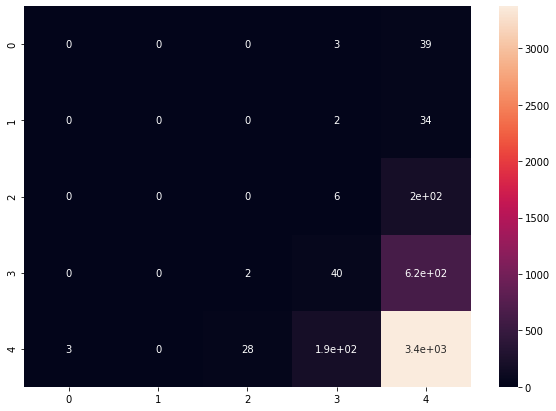

In [37]:
# importing necessary libraries
from sklearn import datasets
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
import seaborn as sn

# X -> features, y -> label
X = alls
y = labels
  
# dividing X, y into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)
  
# training a KNN classifier
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 5).fit(X_train, y_train)
  
# accuracy on X_test
accuracy = knn.score(X_test, y_test)
print(accuracy)
  
# creating a confusion matrix
knn_predictions = knn.predict(X_test) 
cm = confusion_matrix(y_test, knn_predictions)
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True)

knn = KNeighborsClassifier()
knn.fit(x_train, y_train)
#Predict test data set.
y_pred = knn.predict(x_test)
#Checking performance our model with classification report.
print(classification_report(y_test, y_pred))

In [143]:
#List Hyperparameters that we want to tune.
leaf_size = list(range(1,50))
n_neighbors = list(range(1,30))
p=[1,2]
#Convert to dictionary
hyperparameters = dict(leaf_size=leaf_size, n_neighbors=n_neighbors, p=p)
#Create new KNN object
knn_2 = KNeighborsClassifier()
#Use GridSearch
clf = GridSearchCV(knn_2, hyperparameters, cv=10)
#Fit the model
best_model = clf.fit(X,y)
#Print The value of best Hyperparameters
print('Best leaf_size:', best_model.best_estimator_.get_params()['leaf_size'])
print('Best p:', best_model.best_estimator_.get_params()['p'])
print('Best n_neighbors:', best_model.best_estimator_.get_params()['n_neighbors'])

KeyboardInterrupt: 

0.7861233480176212


<AxesSubplot:>

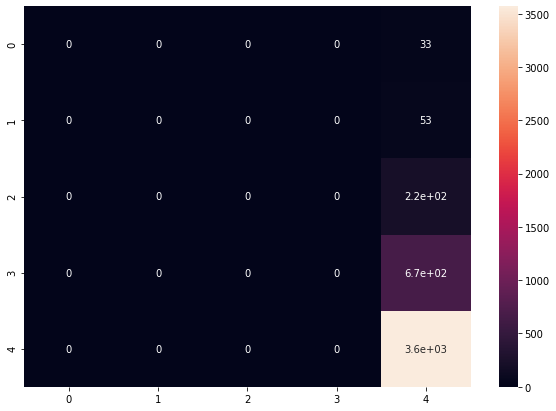

In [134]:
# importing necessary libraries
from sklearn import datasets
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sn
# loading the iris dataset
  
# X -> features, y -> label
X = alls
y = labels
  
# dividing X, y into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)
  
# training a DescisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier
dtree_model = DecisionTreeClassifier(max_depth = 2).fit(X_train, y_train)
dtree_predictions = dtree_model.predict(X_test)
accuracy = dtree_model.score(X_test, y_test)
print(accuracy ) 
# creating a confusion matrix
cm = confusion_matrix(y_test, dtree_predictions)
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True)

0.7788546255506608


<AxesSubplot:>

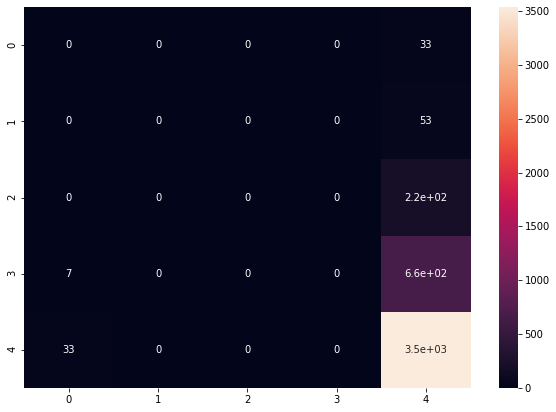

In [135]:
# importing necessary libraries
from sklearn import datasets
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

  
# X -> features, y -> label
X = alls
y = labels
  
# dividing X, y into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)
  
# training a Naive Bayes classifier
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB().fit(X_train, y_train)
gnb_predictions = gnb.predict(X_test)
  
# accuracy on X_test
accuracy = gnb.score(X_test, y_test)
print(accuracy)
  
# creating a confusion matrix
cm = confusion_matrix(y_test, gnb_predictions)
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True)

In [31]:
y.shape

(150,)